# Geoprocessing
## Lesson Goals

We'll walk through some typical topological operations (spatial subsetting, spatial joins, dissolve) with vector data using using `GeoPandas` - followed by a couple 'real world' spatial tasks.  We'll also incorporate a bit of raster processing such as map algebra, cropping, and zonal statistics.

## Spatial Subsetting
We'll work with gages data from the previous section, and incorporate NHD streamlines, basins and HUC12 data using web services to demonstrate spatial subsetting. We'll demonstrate using the `pynhd` library from Taher's [HyRiver software stack](https://github.com/cheginit/HyRiver-examples) to query the [Network Linked Data Index](https://labs.waterdata.usgs.gov/about-nldi/index.html). 

In [1]:
import pandas as pd

infile = "Gages_flow_flowdata.csv"
# infile = 'C:/Users/mweber/GitProjects/AWRA2022GeoWorkshop/Workbooks/Python/Session2/Gages_flow_flowdata.csv'
Use_Cols = ["COMID", "REACHCODE", "STATE", "LON_NHD", "LAT_NHD", "DA_SQ_MILE", "AVE"]
df = pd.read_csv(infile, usecols=Use_Cols, keep_default_na=False, na_values=[""])
df.columns

Index(['COMID', 'REACHCODE', 'STATE', 'DA_SQ_MILE', 'LON_NHD', 'LAT_NHD',
       'AVE'],
      dtype='object')

And again we'll promote our `pandas` dataframe to a `GeoPandas` `GeoDataFrame` as we did in the last section.  Here we'll also use the `explore` method in `GeoPandas` to quickly generate an interactive map of our data, rather than a simple plot with `matplotlib`.

In [2]:
import geopandas as gpd

gages = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.LON_NHD, df.LAT_NHD, crs="EPSG:4269"))
gages.explore()

Gathering the same data we use in our R example follows the example in [HyRiver pynhd nhdplus notebook](https://github.com/cheginit/HyRiver-examples/blob/main/notebooks/nhdplus.ipynb).

In [3]:
import pynhd as nhd
from pynhd import NLDI, NHDPlusHR, WaterData

nldi = NLDI()
station_id = "14187200"

basin = nldi.get_basins(station_id)

In [4]:
SouthSantiam = nldi.navigate_byid(
    fsource="nwissite", fid=f"USGS-{station_id}", navigation="upstreamMain", source="flowlines"
)
HUC12_pp = nldi.navigate_byid(
    fsource="nwissite", fid=f"USGS-{station_id}", navigation="upstreamTributaries", source="huc12pp"
)

In [5]:
SouthSantiam = SouthSantiam.to_crs(3157)
HUC12_pp = HUC12_pp.to_crs(3157)
gages = gages.to_crs(3157)
basin = basin.to_crs(3157)

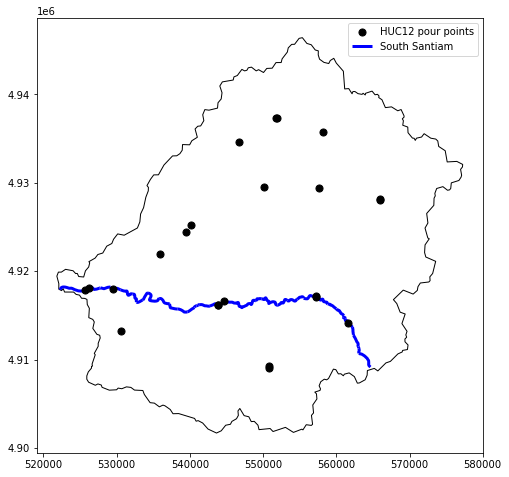

In [6]:
ax = basin.plot(facecolor="none", edgecolor="k", figsize=(8, 8))
HUC12_pp.plot(ax=ax, label="HUC12 pour points", marker="o", markersize=50, color="k", zorder=3)
SouthSantiam.plot(ax=ax, lw=3, color="blue", zorder=2, label="South Santiam")

ax.legend(loc="best")
ax.set_aspect("auto")

In addition to the standard pandas indexing methods, `GeoPandas` also provides coordinate based indexing with the `cx` indexer, which slices using a bounding box. Geometries in the GeoSeries or GeoDataFrame that intersect the bounding box will be returned similar to what we did in our R example

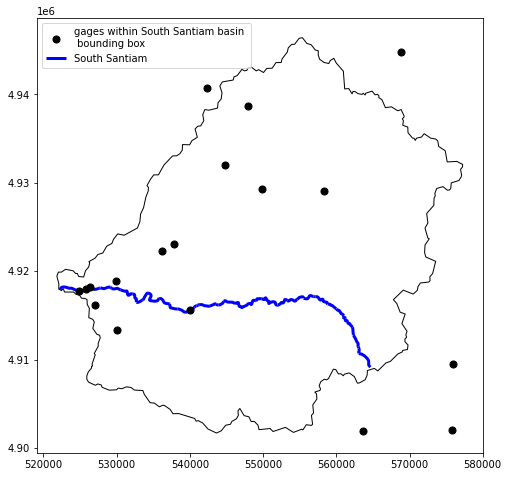

In [9]:
xmin, ymin, xmax, ymax = basin.total_bounds
gages_Santiam = gages.cx[xmin:xmax, ymin:ymax]
ax = basin.plot(facecolor="none", edgecolor="k", figsize=(8, 8))
gages_Santiam.plot(
    ax=ax, label="gages within South Santiam basin \n bounding box", marker="o", markersize=50, color="k", zorder=3
)
SouthSantiam.plot(ax=ax, lw=3, color="blue", zorder=2, label="South Santiam")

ax.legend(loc="best")
ax.set_aspect("auto")

## Spatial Join
A spatial join uses binary predicates such as intersects and crosses to combine two GeoDataFrames based on the spatial relationship between their geometries. From the [GeoPandas Docs](https://geopandas.org/en/stable/gallery/spatial_joins.html):
- In an INNER JOIN (how='inner'), we keep rows from the right and left only where their binary predicate is True. We duplicate them if necessary to represent multiple hits between the two dataframes. We retain attributes of the right and left only if they intersect and lose all rows that do not. An inner join implies that we are interested in retaining the geometries of the left.

Performin an inner join in GeoPandas can be described with SQL syntax:

```python
SELECT pts.geom, pts.id as ptid, polys.id as polyid
FROM pts
INNER JOIN polys
ON ST_Intersects(pts.geom, polys.geom)
```

We'll join gages to our basin as a further filter to our previous spatial subset - in this step we join basin attributes *only for gages within the boundary of the basin* rather than simply subsetting gages that are within a bounding box

In [7]:
gages_within_basin = gages_Santiam.sjoin(basin, how="left")
gages_within_basin

,COMID,REACHCODE,STATE,DA_SQ_MILE,LON_NHD,LAT_NHD,AVE,geometry,index_right
794,0,17090004000315,OR,16.20,-122.047149,44.334465,89.042,POINT (575963.608 4909463.671),NaN
821,0,17090004000307,OR,184.00,-122.049819,44.267875,1012.487,POINT (575836.427 4902064.778),NaN
822,0,17090004000330,OR,11.50,-122.202430,44.267402,72.637,POINT (563656.631 4901882.557),NaN
924,0,17090005000084,OR,26.00,-122.131286,44.652904,109.835,POINT (568880.104 4944760.616),NaN
936,0,17090006000485,OR,1.03,-122.466458,44.618973,7.415,POINT (542329.051 4940762.981),NaN
940,0,17090006000499,OR,7.45,-122.395660,44.599990,52.878,POINT (547961.499 4938693.530),14187200
956,0,17090006000848,OR,99.20,-122.436019,44.540122,648.355,POINT (544804.475 4932020.521),14187200
970,0,17090006000147,OR,104.00,-122.372306,44.515625,624.647,POINT (549886.950 4929336.359),14187200
975,0,17090006000156,OR,74.60,-122.265663,44.512527,398.321,POINT (558365.668 4929062.872),14187200
996,0,17090006008776,OR,271.00,-122.524726,44.459457,1449.048,POINT (537809.396 4923015.614),14187200


The gages that are *within* the basin boundary have NaN for the *index_right* field that was added to the data frame.  

We can drop records that are NaN for that field and plot just those gages that were joined and received the basin ID value in the data table:

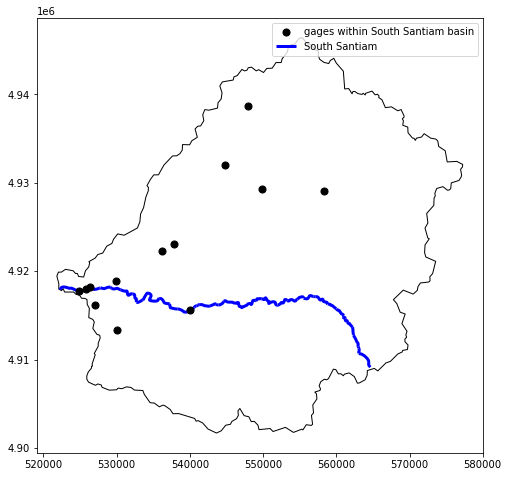

In [8]:
gages_within_basin = gages_within_basin.dropna(subset=['index_right'])

ax = basin.plot(facecolor="none", edgecolor="k", figsize=(8, 8))
gages_within_basin.plot(
    ax=ax, label="gages within South Santiam basin", marker="o", markersize=50, color="k", zorder=3
)
SouthSantiam.plot(ax=ax, lw=3, color="blue", zorder=2, label="South Santiam")

ax.legend(loc="best")
ax.set_aspect("auto")

## Zonal Statistics

In [13]:
# from xrspatial import zonal_stats
# import xarray as xr
import geopandas as gpd
import rasterio
import rioxarray